In [1]:
import os
import numpy as np
import cv2
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
%matplotlib inline

# Show & save two images side-by-side for comparison
def show_two_img(first_img, sec_img, first_imgtitle="", sec_imgtitle="", imgname=""):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(first_img,cmap="gray")
    ax1.set_title(first_imgtitle+" Image", fontsize=30)
    ax2.imshow(sec_img,cmap="gray")
    ax2.set_title(sec_imgtitle+" Image", fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig("output_images/"+imgname+".jpg")

# Show & save single images
def show_single_img(img,img_title="",imgname=""):
    f, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
    f.tight_layout()
    ax1.imshow(img,cmap="gray")
    ax1.set_title(img_title+" Image", fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig("output_images/"+imgname+".jpg")


nx = 9         
ny = 6
objpoints = []
imgpoints = []
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
gray_shape = None

# Compute camera calibration matrix and distortion coefficients
for image in os.listdir("camera_cal"):
    img = cv2.imread("camera_cal/"+image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        gray_shape = gray

ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [2]:
# Pipeline
def undistort(img):
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist


def s_channel_binary(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    thresh = (50, 200)
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary

def r_channel_binary(img):
    r_channel = img[:,:,0]
    thresh = (200, 255)
    binary = np.zeros_like(r_channel)
    binary[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
    return binary

#def h_channel_binary(img):
#    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#    h_channel = hls[:,:,0]
#    thresh = (15, 100)
#    binary = np.zeros_like(h_channel)
#    binary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
#    return binary

def sobelx_transform(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 30
    thresh_max = 130
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def binary_image(img):
    s_channel = s_channel_binary(img)
    #h_channel = h_channel_binary(img)
    r_channel = r_channel_binary(img)
    sobel_x = sobelx_transform(img)
    color_binary = np.dstack(( np.zeros_like(sobel_x), sobel_x, s_channel))
    combined_binary = np.zeros_like(sobel_x)
    combined_binary[(s_channel == 1) | (sobel_x == 1) | (r_channel == 1)] = 1
    return combined_binary

src = np.float32(
        [[270, 675],
          [587, 455],
          [693, 455],
          [1035, 675]])
dst = np.float32(
        [[270, 675],
          [270, 20],
          [1035, 20],
          [1035, 675]])

def perspective_transform(img):
    binary = binary_image(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0]) 
    M = cv2.getPerspectiveTransform(src,dst)
    undist=undistort(binary)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped

def inv_perspective_transform(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0]) 
    invM = cv2.getPerspectiveTransform(dst,src)
    return invM

def runpipeline(img):
    binary_warped=perspective_transform(img)
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    quadratic_coeff = 3e-4
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #return result
    
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    leftx=leftx[::-1] 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = inv_perspective_transform(img)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(undistort(img), 1, newwarp, 0.3, 0)
    
    imagex = result.shape[1]
    imagey = result.shape[0]
    
    leftlanepoint = left_fit_cr[0]*imagey**2 + left_fit_cr[1]*imagey + left_fit[2]
    # right lane point in the bottom
    rightlanepoint = right_fit_cr[0]*imagey**2 + right_fit_cr[1]*imagey + right_fit_cr[2]
    # Center of the lane
    lanecenter = ((leftlanepoint + rightlanepoint)/2)
    # Car position calculated by taking difference in lane center and frame center
    camcenter = (imagex/2)
    carpos =  (camcenter - lanecenter) * xm_per_pix
    if carpos > 0:
        msg = "Right of center "+str(abs(round(carpos, 2)))+" (m)"
    else:
        msg = "Left of center "+str(abs(round(carpos, 2)))+" (m)"    
    cv2.putText(result, str("Curvature "+str((left_curverad+right_curverad)//2)+" (m)") ,(10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)
    cv2.putText(result, str("Car position:  "+msg) ,(10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)
    return result

C:\Users\stambde\AppData\Local\Continuum\Miniconda2\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


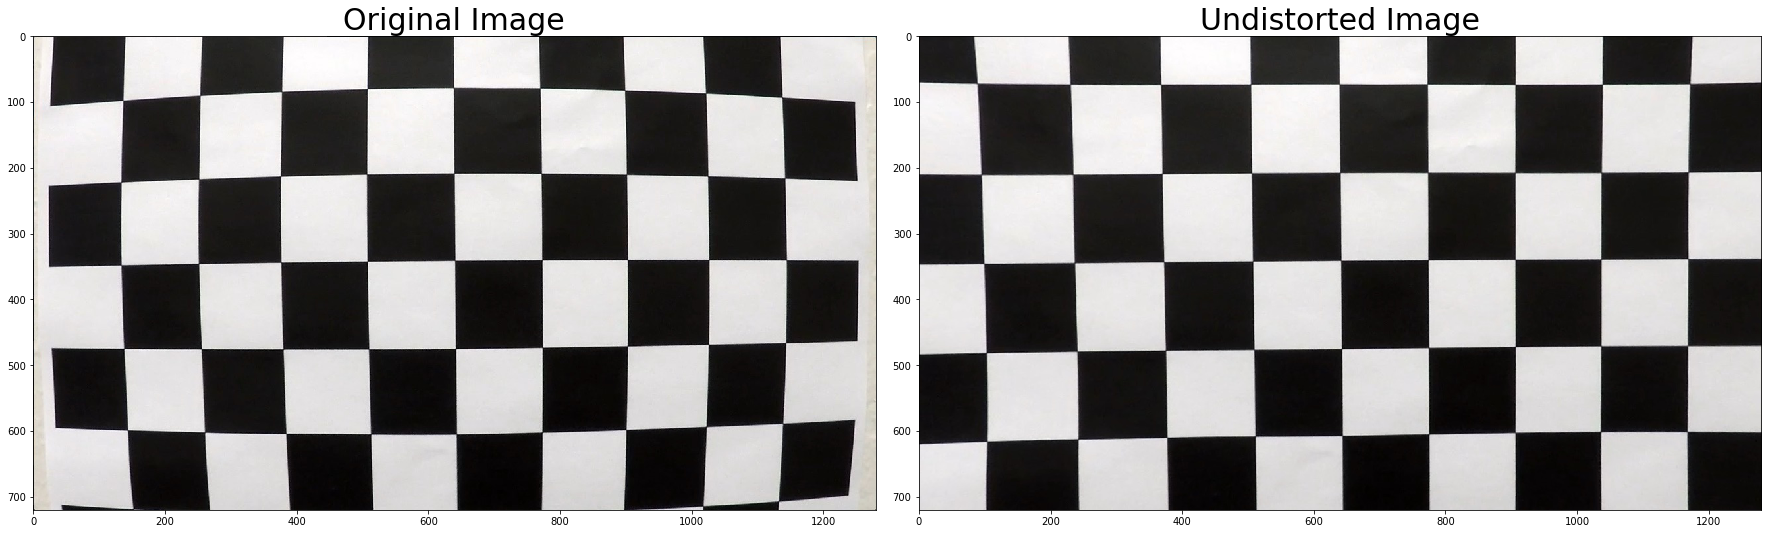

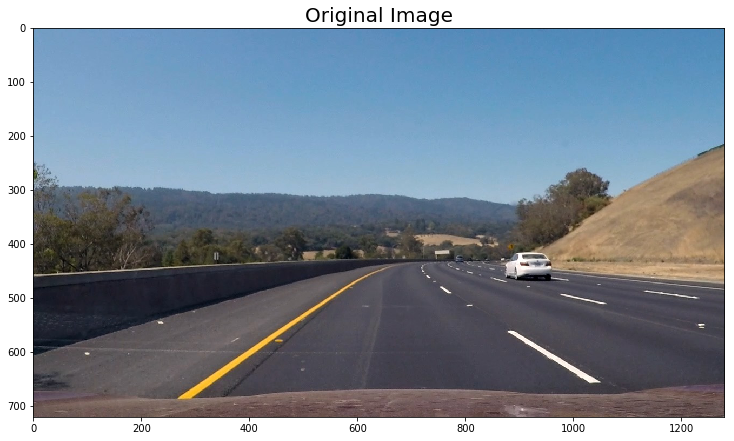

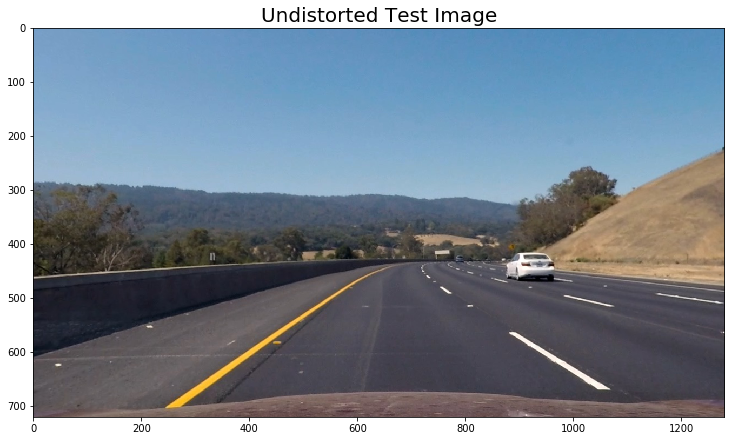

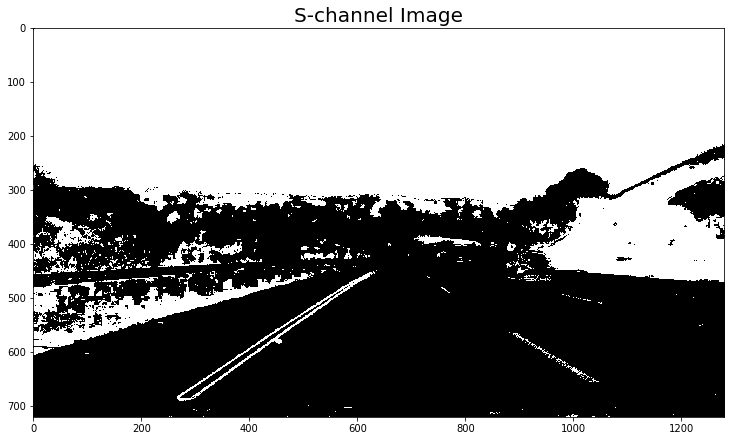

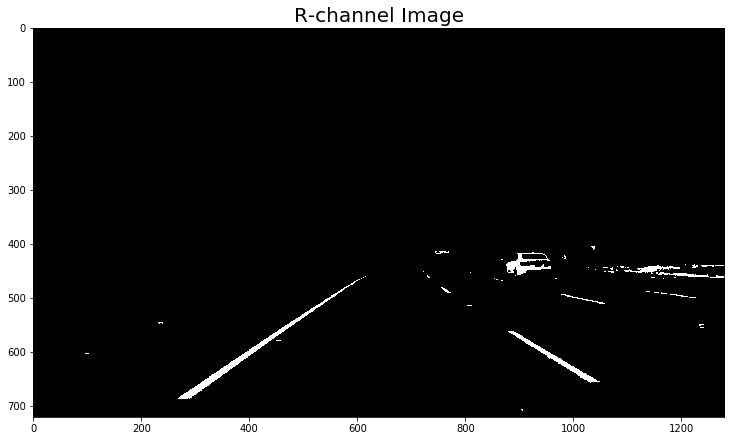

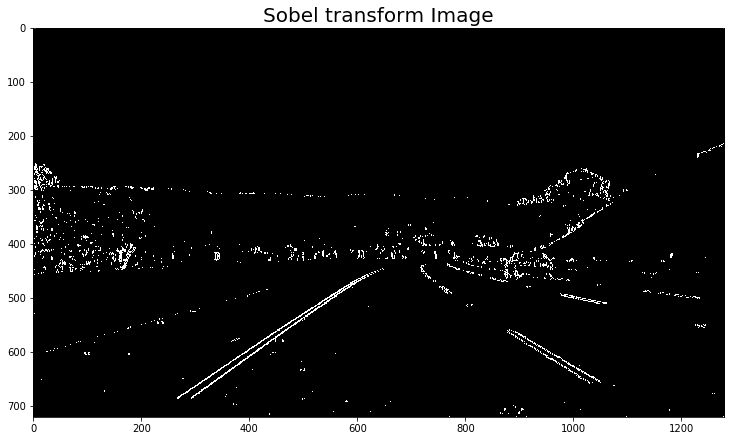

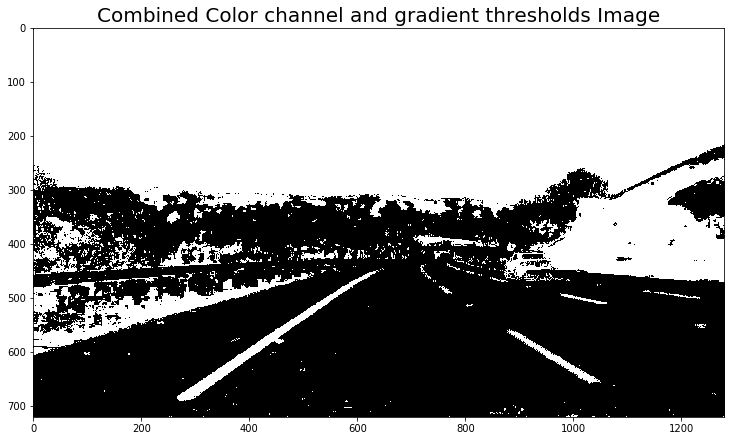

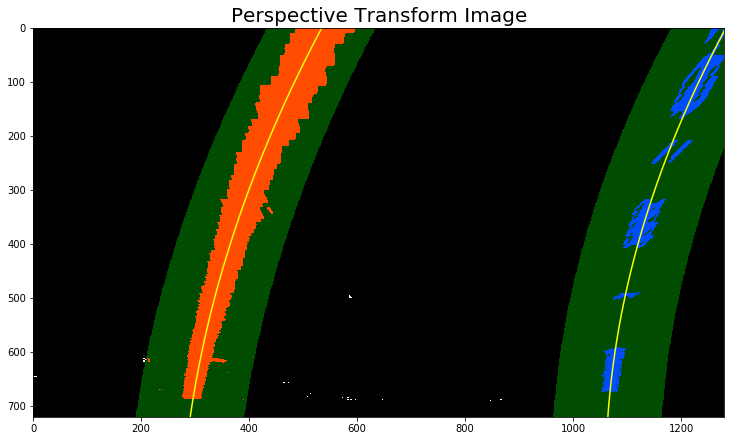

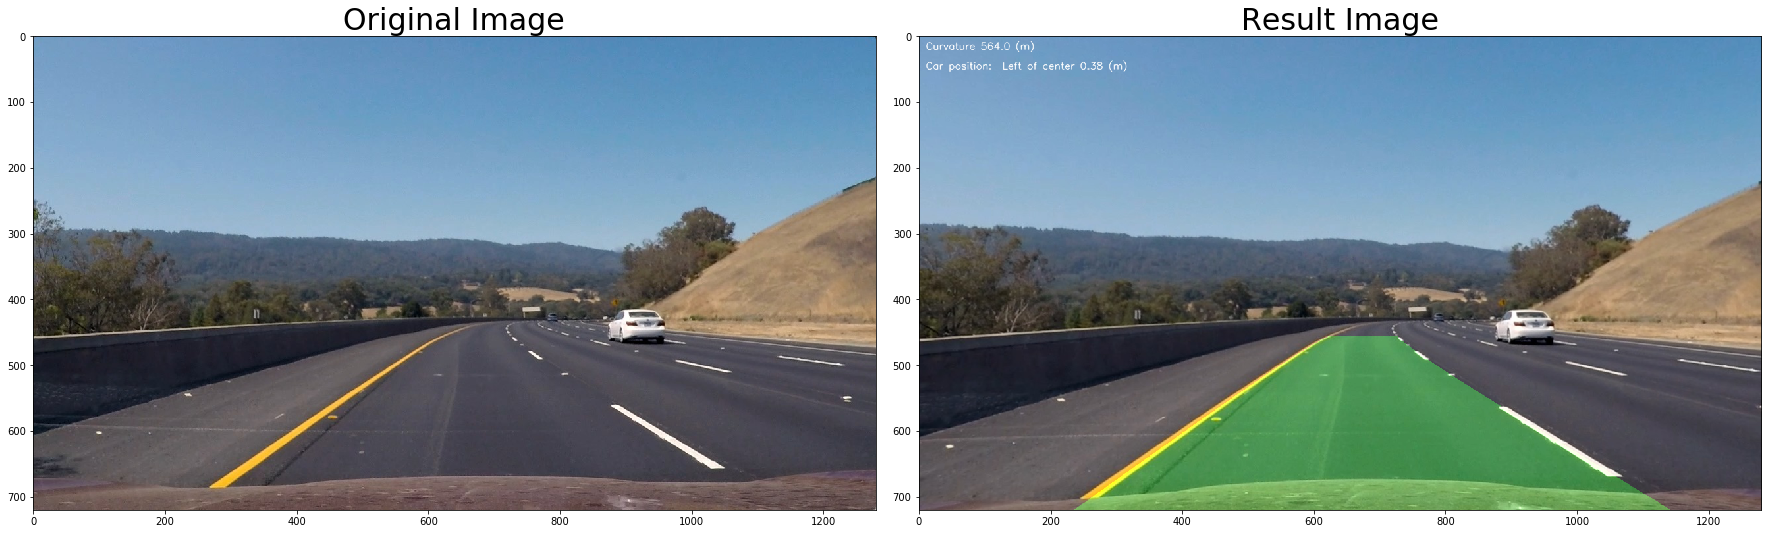

In [3]:
# Test Distortion with Chessboard image
img = mpimage.imread('camera_cal/calibration1.jpg')
undst = undistort(img)
show_two_img(img, undst, "Original", "Undistorted", "camera_cal_undistorted")

# Test pipeline 
def test(img):
    undst = undistort(img)
    show_single_img(undst, "Undistorted Test", "undistorted test image" )
    
    s_channel = s_channel_binary(img)
    show_single_img(s_channel, "S-channel", "s-channel" )
    
    #h_channel = h_channel_binary(img)
    #show_single_img(h_channel, "H-channel","h-channel")
    
    r_channel = r_channel_binary(img)
    show_single_img(r_channel, "R-channel","r-channel")
    
    sobel = sobelx_transform(img)
    show_single_img(sobel, "Sobel transform", "sobelx")

    binary = binary_image(img)
    show_single_img(binary, "Combined Color channel and gradient thresholds", "combined binary")

    perspective = perspective_transform(img)
    show_single_img(perspective, "Perspective Transform", "perspective",)
    
    result = runpipeline(img)
    show_two_img(img, result, "Original", "Result", "result")
    #show_img(img,result,"Original","result")


img = mpimage.imread('test_images/'+'test3.jpg')
show_single_img(img, "Original", "original")
test(img)

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:24<00:00,  3.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 26s


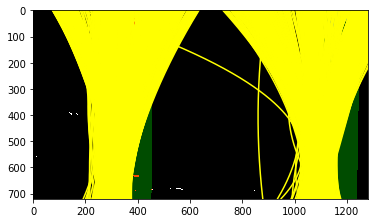

In [5]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(runpipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
